# Mini-Project 2 
## Multi-Class Logistic Regression and Gradient Descent

Chenxuan Zhou  <br> 
Irene Huang    <br>
Jiahua Liang   


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import timeit
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.datasets import fetch_openml

## Data Preprocessing

In [2]:
def data_split(X, y, num_folds=5):

  num_data = X.shape[0]
  # 80% of data for training, 20% for test
  num_test = num_data // 5
  num_rest = num_data - num_test
  X_rest = X[:num_rest]
  y_rest = y[:num_rest]
  X_test = X[num_rest:]
  y_test = y[num_rest:]
  # get the number of data samples in each fold
  fold_size = num_rest // num_folds
  # create lists to hold features and labels in each split of cross-validation
  X_train, y_train, X_val, y_val = ([] for i in range(4))
  # further split into training set and validation set for cross-validation
  for i in range(num_folds):
    train_indices = []
    #get the validation indices
    val_indices = list(range(i * fold_size, (i+1)*fold_size))
    X_val.append(X_rest[val_indices])
    y_val.append(y_rest[val_indices])
    #get the training indices
    train_indices = list(range(i*fold_size)) + list(range((i+1)*fold_size, num_rest))
    X_train.append(X_rest[train_indices])
    y_train.append(y_rest[train_indices])

  return X_train, y_train, X_val, y_val, X_test, y_test
        

### Dataset 1: Digits

In [3]:
from sklearn.datasets import load_digits 
digits = load_digits() 
X1 = digits.data # features
y1 = digits.target # labels
print("Dataset contains nan ?: ", np.isnan(X1).any()) # check missing data in features
print(X1.shape)
print(y1.shape)

Dataset contains nan ?:  False
(1797, 64)
(1797,)


In [4]:
# standardize features: z = (x - u) / s
scaler1 = StandardScaler()
X1 = scaler1.fit_transform(X1)
print(X1.shape)
print(y1.shape)


(1797, 64)
(1797,)


In [5]:
# one hot encoding of labels
lb1 = LabelBinarizer()
y1 = lb1.fit_transform(y1)
print(y1.shape)

(1797, 10)


In [6]:
# Split data
X1_train, y1_train, X1_val, y1_val, X1_test, y1_test = data_split(X1, y1, num_folds=5)
print(len(X1_train))
print(X1_train[0].shape)
print(y1_train[0].shape)

5
(1151, 64)
(1151, 10)


### Dataset 2: Vehicle <br>
source: https://www.openml.org/d/54 

In [7]:
# import dataset from OpenML
vehicle = fetch_openml('vehicle');
cols = vehicle.feature_names
vehicle_df = pd.DataFrame(vehicle.data, columns=cols)
vehicle_df['Class'] = vehicle.target

In [8]:
#vehicle_df = pd.read_csv('dataset_54_vehicle.csv')
X2 = vehicle_df.iloc[:, :-1].values # features
y2 = vehicle_df.iloc[:, -1].values # labels
print("Does dataset contain nan? :", np.isnan(X2).any()) # check missing data in features
print(X2.shape)
print(y2.shape)

Does dataset contain nan? : False
(846, 18)
(846,)


In [9]:
# standardize features: z = (x - u) / s
scaler2 = StandardScaler()
X2 = scaler2.fit_transform(X2)
print(X2.shape)
print(y2.shape)


(846, 18)
(846,)


In [10]:
# one hot encoding for classes
lb2 = LabelBinarizer()
y2 = lb2.fit_transform(y2)
print(y2.shape)

(846, 4)


In [11]:
# Split data
X2_train, y2_train, X2_val, y2_val, X2_test, y2_test = data_split(X2, y2, num_folds=5)
print(X2_test.shape)
print(y2_test.shape)

(169, 18)
(169, 4)


#### Visualization of Dataset 2 Features

['bus', 'opel', 'saab', 'van']


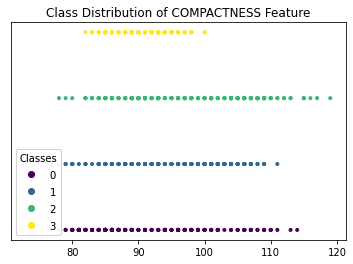

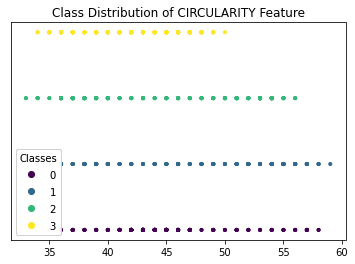

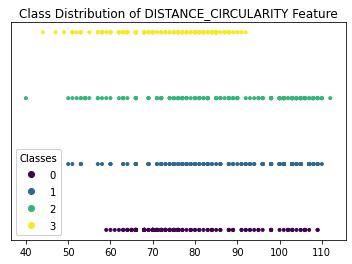

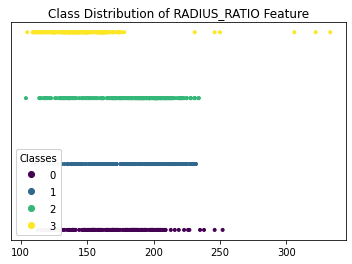

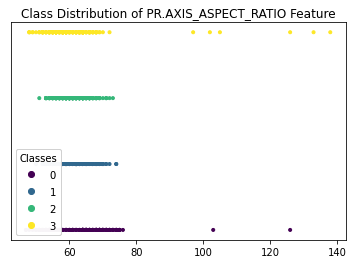

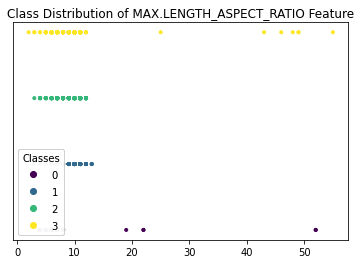

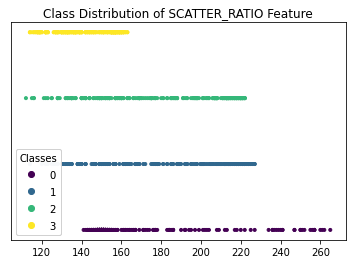

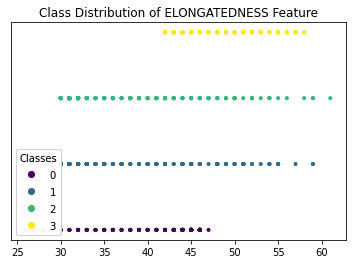

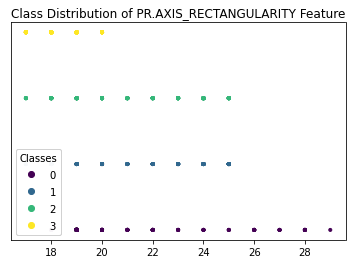

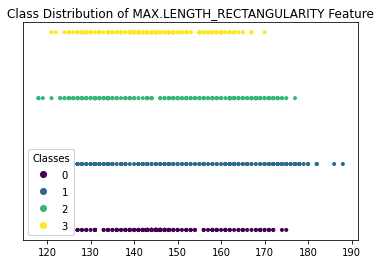

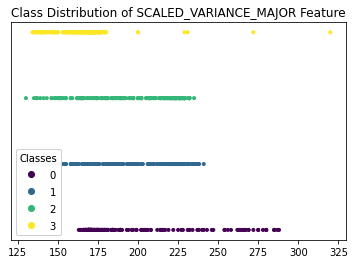

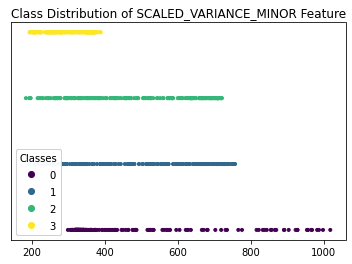

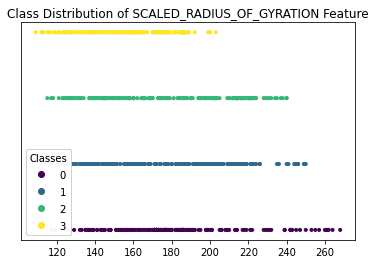

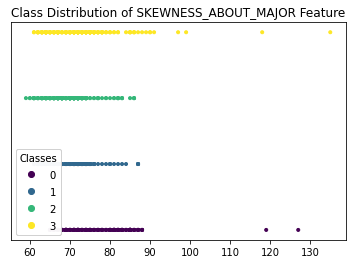

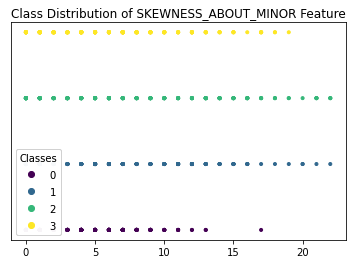

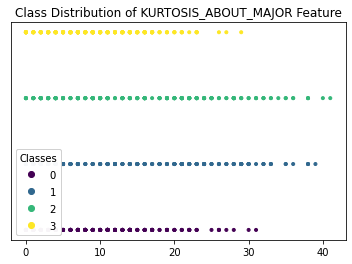

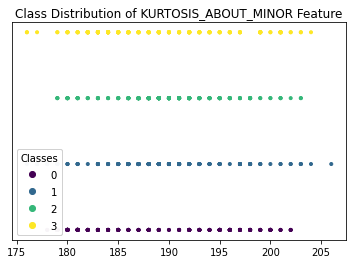

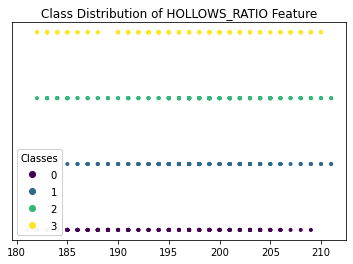

In [12]:
# Feature visualization before standardization
#vehicle_df = pd.read_csv('dataset_54_vehicle.csv').sort_values('Class').reset_index(drop=True)
vehicle_sorted_df = vehicle_df.sort_values('Class').reset_index(drop=True)

features = vehicle_sorted_df.iloc[:, :-1]
classes = vehicle_sorted_df.iloc[:, -1].values
class_names = sorted(list(set(classes)))

def to_int(c) :
    return 0 if c=='bus' else (1 if c=='opel' else (2 if c=='saab' else 3))
classes = np.array([to_int(c) for c in classes])

print(sorted(list(set(class_names))))

for feature in features :
    
    fig, ax = plt.subplots()
    
    points = features[feature].values
    scatter = ax.scatter(points, classes-3, marker='.', c=classes)
    
    legend1 = ax.legend(*scatter.legend_elements(),loc="lower left", title="Classes")
    ax.add_artist(legend1)
    
    plt.title('Class Distribution of {} Feature'.format(feature))
    plt.yticks([])
    plt.show()



['bus', 'opel', 'saab', 'van']


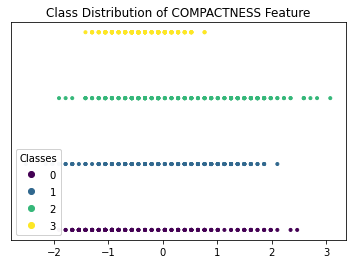

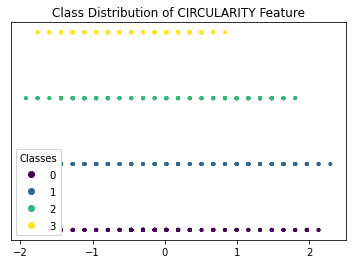

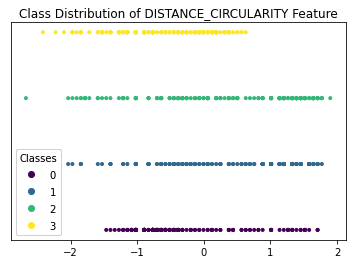

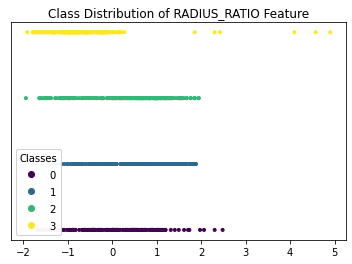

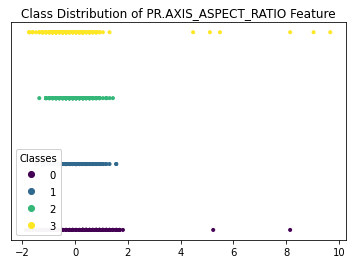

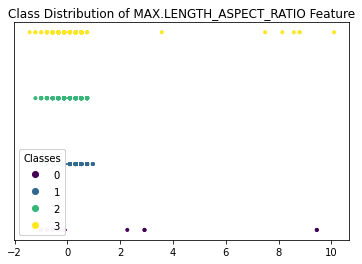

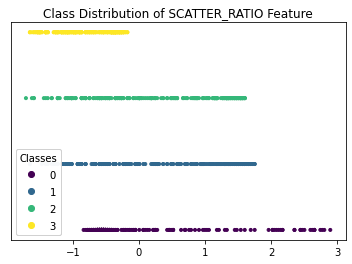

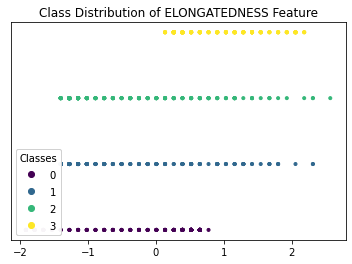

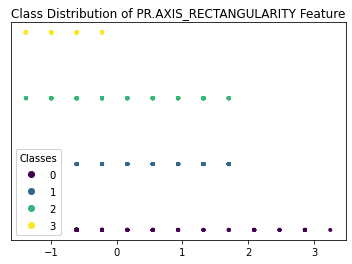

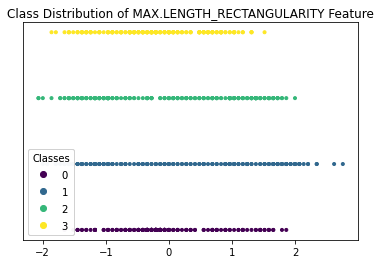

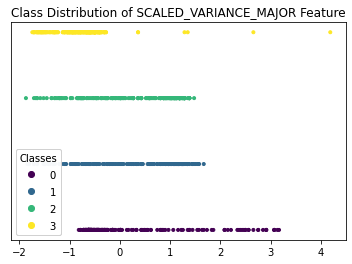

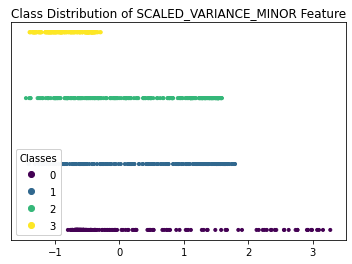

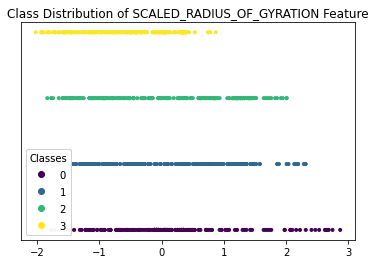

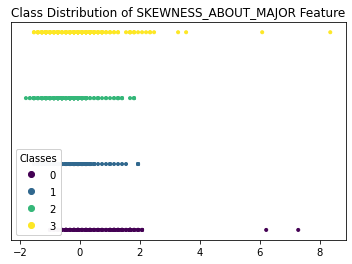

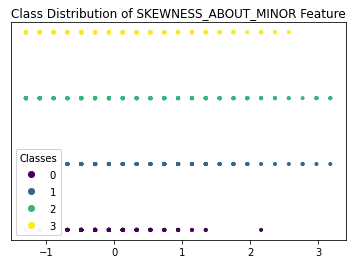

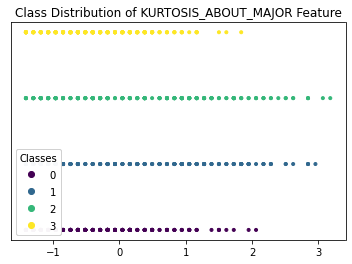

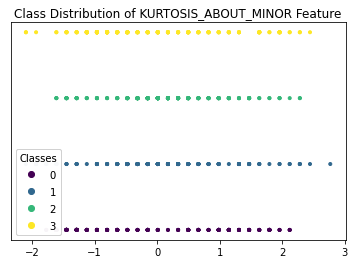

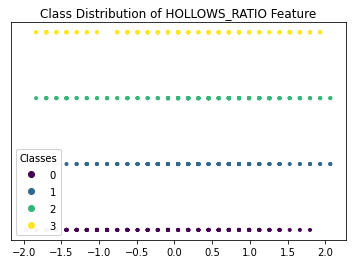

In [13]:
# Feature visualization after standardization
vehicle_sorted_df = vehicle_df.sort_values('Class').reset_index(drop=True)

features = scaler2.fit_transform(vehicle_df.iloc[:, :-1])
features_name = vehicle_df.columns
classes = vehicle_df.iloc[:, -1].values
class_names = sorted(list(set(classes)))

def to_int(c) :
    return 0 if c=='bus' else (1 if c=='opel' else (2 if c=='saab' else 3))
classes = np.array([to_int(c) for c in classes])

print(sorted(list(set(class_names))))

for i in range(features.shape[1]) :
    
    fig, ax = plt.subplots()

    points = features[:,i]
    scatter = ax.scatter(points, classes-3, marker='.', c=classes)
    
    legend1 = ax.legend(*scatter.legend_elements(),loc="lower left", title="Classes")
    ax.add_artist(legend1)
    
    plt.title('Class Distribution of {} Feature'.format(features_name[i]))
    plt.yticks([])
    plt.show()



## Mini-batch Gradient Descent with Momentum

In [14]:
class GradientDescent: 
    def __init__(self, lr, beta, batch_size, max_T, epoch, lambd, X_val, y_val):
      self.lr = lr
      self.beta = beta
      self.batch_size = batch_size
      self.max_T = max_T 
      self.X_val = X_val 
      self.y_val = y_val 
      self.lambd = lambd
      self.epoch = epoch
    
    # returns new weights
    def run(self, gradient_fn, X, y, w):

      # Step 1: Split into mini-batch 
      
      # Shuffle data 
      p = np.random.permutation(len(X))

      # Split into mini-batch and their corresponding y
      batch_num = math.ceil(len(X)/self.batch_size)
      mini_batches = np.array_split(X[p], batch_num)
      mini_ys = np.array_split(y[p], batch_num)    
      
      # Iteration set-up
      N,D = X.shape
      C = y.shape[1]

      self.X_val = np.column_stack([self.X_val,np.ones(self.X_val.shape[0])])
      w = w # w{t}
      dw = np.zeros((C,D)) # Δw{t}
      grad = np.inf # ∇JB(w{t})
      iter = 0

      # Termination condition set
      T = 0
      val_acc_history = []
      w_history = []
      
      while T < self.max_T and iter < self.epoch: 
        iter += 1

        for mini_batch, mini_y in zip(mini_batches, mini_ys): 
          # Step 2: Calculate Gradient
          grad = gradient_fn(mini_batch, mini_y, w, self.lambd)  # softmax_cost_fn

          # Step 3: Update W using momentum 
          dw = self.beta * dw + (1-self.beta) * grad
          w = w - self.lr * dw
                
          # Step 4: Calculate training & validation set accuracy using w
          train_acc = get_accuracy(softmax(mini_batch, w), mini_y)
          val_acc = get_accuracy(softmax(self.X_val, w), self.y_val)
          # print('Train accuracy : {}, Validation accuracy : {}'.format(train_acc, val_acc))

          # Step 5: Check termination condition & save partial result
          if len(val_acc_history) != 0:
            if val_acc <= val_acc_history[-1]:
              T += 1 # val_acc not increase
              if T >= self.max_T:
                break
            else :
              T = 0 
          
          val_acc_history.append(val_acc)
          w_history.append(w)
      w = w_history[np.argmax(val_acc_history)]
      
      return (w, iter)

## Softmax Function

In [15]:
def softmax(x, w):
    z = np.matmul(x, w.T)
    z -= np.max(z)
    prob = np.exp(z) / np.sum(np.exp(z), axis=0)
    return prob

## Cost Function

In [16]:
def cost_softmax_fn(x, y, w, lambd):
    N, D = x.shape
    yh = softmax(x, w)
    grad = np.matmul((yh - y).T, x)/N
    return grad

In [17]:
def cost_softmax_fn_l1(x, y, w, lambd):
    N, D = x.shape
    yh = softmax(x, w)
    grad = np.matmul((yh - y).T, x) 
    grad[:,1:] += lambd * np.sign(w[:,1:])/N # ignore w_0 (bias)
    return grad

In [18]:
def cost_softmax_fn_l2(x, y, w, lambd):
    N, D = x.shape
    yh = softmax(x, w)
    grad = np.matmul((yh - y).T, x)/N
    grad[:,1:] += lambd * w[:,1:] # ignore w_0 (bias)
    return grad

## Multi-class Logistic Regression (Softmax Regression)


In [19]:
class Logistic_Regression:
    def __init__(self, add_bias=True, regularization=None):
        self.add_bias = add_bias 
        self.regularization = regularization
    
    def fit(self, x, y, optimizer):
        if x.ndim == 1: 
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])

        N,D = x.shape
        C = y.shape[1]
        w0 = np.zeros((C, D))
        if self.regularization == None: 
          cost_fn = cost_softmax_fn
        elif self.regularization == 'l1': 
          cost_fn = cost_softmax_fn_l1
        elif self.regularization == 'l2':
          cost_fn = cost_softmax_fn_l2
          
        self.w, self.iter = optimizer.run(cost_fn, x, y, w0)
        return self


    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Np = x.shape[0]
        if self.add_bias: 
            x = np.column_stack([x, np.ones(Np)])
            
        # Softmax 
        yh = softmax(x, self.w)
        
        return yh 
        
        

## Multi-Class Logistic Regression Training and Testing 

### Evaluation functions

In [ ]:
def get_accuracy(y_predict, y): 
    y_predict = np.argmax(y_predict, axis=1)
    y = np.argmax(y, axis=1)
    accuracy = sum(y_predict == y)/(float(len(y)))

    return accuracy 

In [21]:
# Hyperparameters 
batch_size = [10, 20, 40, 60, 80, 100]
learning_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
beta_param = [0.1, 0.2, 0.4, 0.6, 0.8, 0.9]
lambda_param = [0.001, 0.01, 0.1, 10]

max_T = 20
epoch = 50
k = 5 # Number of fold 

hyper_params = ['learning_rate', 'beta', 'batch_size']
hyperparam_dict = dict(zip(hyper_params, [learning_rate, beta_param, batch_size])) 

In [ ]:
def get_val_accuracy(lr, beta, bs, max_T, lambd, reg, X_train_list, y_train_list, X_val_list, y_val_list):
  accuracy = 0
  lr_model_list = [] 

  for i in range(k):
    optimizer = GradientDescent(lr, beta, bs, max_T, epoch, lambd, X_val_list[i], y_val_list[i])
    model = Logistic_Regression(True, reg)
    lr_model = model.fit(X_train_list[i], y_train_list[i], optimizer)  # return the best model with the optimal weight 
    y_predict = lr_model.predict(X_val_list[i]) # Prediction using the optimal weight 
    accuracy += get_accuracy(y_predict, y_val_list[i])  
    lr_model_list.append(lr_model)

  avg_accuracy = accuracy/k   
  return avg_accuracy, lr_model_list

In [ ]:
def best_hyperparameters(X_train_list, y_train_list, X_val_list, y_val_list, reg): 
  '''
  Find the best combination of hyperparameters given the training and validation set, model name, and whether to include regularization 
  :return : Best accuracy, Best combination of hyperparameters, and best model list 
  '''
  max_accuracy = 0
  for lr in learning_rate: 
      for beta in beta_param:
        for bs in batch_size: 
          if reg == None: 
            avg_accuracy, lr_model_list = get_val_accuracy(lr, beta, bs, max_T, None, reg, X_train_list, y_train_list, X_val_list, y_val_list)
            # print("lr", lr, "beta", beta, "bs", bs)
            if (avg_accuracy > max_accuracy): 
              max_accuracy = avg_accuracy     # Find the max accuracy 
              hyper_list = [lr, beta, bs]
              hyper_params = ['learning_rate', 'beta', 'batch_size', 'lambda']
              new_dict = dict(zip(hyper_params, hyper_list))  # A dictionary that contains the best combination of the hyperparameters 
              best_model_list = lr_model_list
          elif reg == 'l1' or reg == 'l2':
            for lambd in lambda_param: 
              avg_accuracy, lr_model_list = get_val_accuracy(lr, beta, bs, max_T, lambd, reg, X_train_list, y_train_list, X_val_list, y_val_list)
              # print("lr", lr, "beta", beta, "bs", bs, "lambda", lambd)
              if (avg_accuracy > max_accuracy): 
                max_accuracy = avg_accuracy     # Find the max accuracy 
                hyper_list = [lr, beta, bs, lambd]
                hyper_params = ['learning_rate', 'beta', 'batch_size', 'lambda']
                new_dict = dict(zip(hyper_params, hyper_list))  # A dictionary that contains the best combination of the hyperparameters 
                best_model_list = lr_model_list

  return max_accuracy, new_dict, best_model_list

In [ ]:
def test_set_evaluation(X_test, y_test, best_model_list): 
  '''
  Evaluation on the test set 
  '''
  accuracy = 0
  for lr_model in best_model_list:
    y_predict = lr_model.predict(X_test) # Prediction using the optimal weight 
    accuracy += get_accuracy(y_predict, y_test)  
  avg_accuracy = accuracy/5
  print("By using the best combination of hyperparameters {}, the average accuracy on the test set is {}".format(new_dict, avg_accuracy))

In [ ]:
def accuracy_plot(param_name, train_accuracy, val_accuracy, hyper_param_list, dataset): 
  '''
  Plot the training and validation accuracy for several choices of hyperparameter 

  :param param_name: learning rate, batch size or beta 
  :param dataset: 'dataset 1' or 'dataset 2' 
  '''
  fig, ax = plt.subplots(figsize=(7,5))

  lines = []
 
  lines += ax.plot(hyper_param_list, train_accuracy, color=np.random.rand(3),marker='.')
  lines += ax.plot(hyper_param_list, val_accuracy, color=np.random.rand(3),marker='.')

  ax.legend(lines, ['Training', 'Validation'],
            loc='upper right', frameon=True, ncol=4)

  ax.set_xlabel(param_name)
  ax.set_ylabel("Accuracy")  
  ax.grid(axis='x')
  ax.grid(axis='y')
  name = '{} Multi-Class LR for {} - Training and Validation Curve'.format(param_name, dataset)
  ax.set_title(name, 
             fontsize = 14) 

  fig.savefig(name, bbox_inches='tight')
  plt.show()

In [26]:
def convergence_time_plot(param_name, num_iter, hyper_param_list, dataset): 
  ''' 
  Plot the convergence time (number of iteration) for several choices of hyperparameter 
  '''
  num_iter = np.average(num_iter, axis = 0)
  fig, ax = plt.subplots(figsize=(7,5))
 
  lines = ax.plot(hyper_param_list, num_iter, color=np.random.rand(3),marker='.')

  ax.set_xlabel(param_name)
  ax.set_ylabel("Convergence Time")  
  ax.grid(axis='x')
  ax.grid(axis='y')
  name = '{} Multi-Class LR for {} - Convergence Time Curve'.format(param_name, dataset)
  ax.set_title(name, 
             fontsize = 14) 

  fig.savefig(name, bbox_inches='tight')
  plt.show()

In [27]:
def performance_evaluation(param_name, new_dict, X_train_list, y_train_list, X_val_list, y_val_list, dataset): 
  '''
  We evaluate the performance and run-time of our algorithm by changing one of the hyperparameters -- batch_size 
  and plot the training and validation curves for different choices of batch_size 

  :param param_name: 'learning_rate', 'beta', 'batch_size', 'lambda'
  :param dataset: 'dataset 1' or 'dataset 2' 
  '''
    
  hyper_param_list = hyperparam_dict[param_name]
  training_accuracy = np.empty([k, len(hyper_param_list)])
  val_accuracy = np.empty([k, len(hyper_param_list)])
  run_time = np.empty([k, len(hyper_param_list)])
  num_iter = np.empty([k, len(hyper_param_list)])

  for i in range(k):
    
      for j, param in enumerate(hyper_param_list): 

        start = timeit.default_timer()
        if param_name == 'batch_size':
          lr = new_dict['learning_rate']
          beta = new_dict['beta']
          optimizer = GradientDescent(lr, beta, param, max_T, epoch, None, X_val_list[i], y_val_list[i])
        elif param_name == 'learning_rate': 
          bs = new_dict['batch_size']
          beta = new_dict['beta']
          optimizer = GradientDescent(param, beta, bs, max_T, epoch, None, X_val_list[i], y_val_list[i])
        elif param_name == 'beta':
          bs = new_dict['batch_size']
          lr = new_dict['learning_rate']
          optimizer = GradientDescent(lr, param, bs, max_T, epoch, None, X_val_list[i], y_val_list[i])


        model = Logistic_Regression(True, None)
        lr_model = model.fit(X_train_list[i], y_train_list[i], optimizer)
        num_iter[i][j] = lr_model.iter

        stop = timeit.default_timer()

        y_train_predict = lr_model.predict(X_train_list[i])
        y_val_predict = lr_model.predict(X_val_list[i])

        training_accuracy[i][j] = get_accuracy(y_train_predict, y_train_list[i])
        val_accuracy[i][j] = get_accuracy(y_val_predict, y_val_list[i])
        run_time[i][j] = stop - start
     
  
  training_accuracy = np.average(training_accuracy, axis=0)
  val_accuracy = np.average(val_accuracy, axis=0)
  run_time = np.average(run_time, axis=0)
  accuracy_plot(param_name, training_accuracy, val_accuracy, hyper_param_list, dataset)
  convergence_time_plot(param_name, num_iter, hyper_param_list, dataset)

### Multi-Class Logistic Regression for Dataset 1

#### No Regularization

In [ ]:
# Find the best combination of hyperparameters using the training and validation set -- without regularization 
max_accuracy, new_dict, best_model_list = best_hyperparameters(X1_train, y1_train, X1_val, y1_val, None)
print('Best accuracy : {},  best hyperparameters: {}'.format(max_accuracy, new_dict))

Best accuracy : 0.9094076655052264,  best hyperparameters: {'learning_rate': 0.01, 'beta': 0.1, 'batch_size': 10}


In [ ]:
# Performance on the test set 
test_set_evaluation(X1_test, y1_test, best_model_list)

By using the best combination of hyperparameters {'learning_rate': 0.01, 'beta': 0.1, 'batch_size': 10}, the average accuracy on the test set is 0.8256267409470752


[0.9178106  0.91138141 0.90842745 0.90668983 0.9004344  0.9018245 ] [0.90452962 0.9010453  0.89756098 0.89268293 0.89477352 0.88989547] [10, 20, 40, 60, 80, 100]


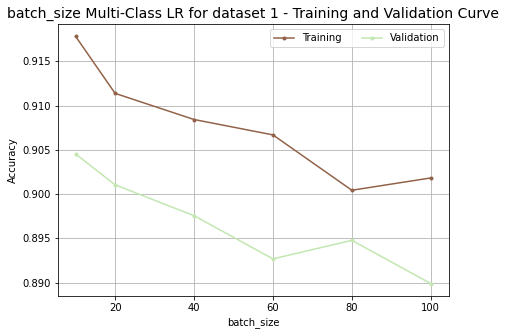

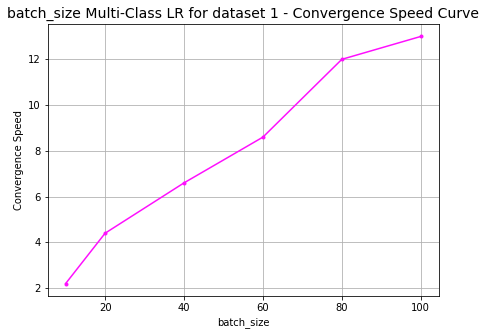

Average training accuracy [0.9178106  0.91138141 0.90842745 0.90668983 0.9004344  0.9018245 ]
Average validation accuracy [0.90452962 0.9010453  0.89756098 0.89268293 0.89477352 0.88989547]
Average run time [0.24392101 0.31141886 0.256171   0.25025567 0.27732712 0.25419685]


In [ ]:
# Performance evaluation given different batch sizes 
performance_evaluation('batch_size', new_dict, X1_train, y1_train, X1_val, y1_val, 'dataset 1')

[0.8872285  0.92111208 0.8465682  0.82884448 0.81303215] [0.86202091 0.90801394 0.90313589 0.87735192 0.87108014] [0.001, 0.01, 0.1, 0.2, 0.3]


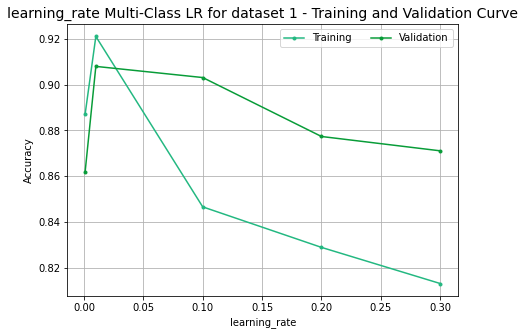

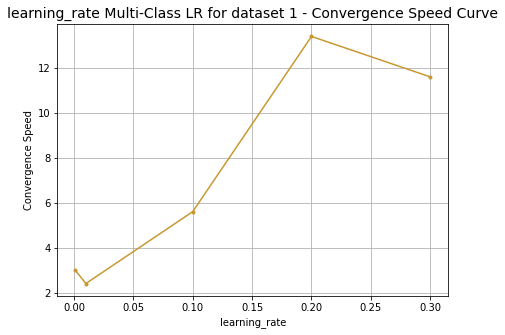

Average training accuracy [0.8872285  0.92111208 0.8465682  0.82884448 0.81303215]
Average validation accuracy [0.86202091 0.90801394 0.90313589 0.87735192 0.87108014]
Average run time [0.36521701 0.29319604 0.68415831 1.64711491 1.4414696 ]


In [ ]:
# Performance evaluation given different learning rate 
performance_evaluation('learning_rate', new_dict, X1_train, y1_train, X1_val, y1_val, 'dataset 1')

[0.91311903 0.91155517 0.91989574 0.91989574 0.91833189 0.91433536] [0.90313589 0.90034843 0.90662021 0.90662021 0.90313589 0.89756098] [0.1, 0.2, 0.4, 0.6, 0.8, 0.9]


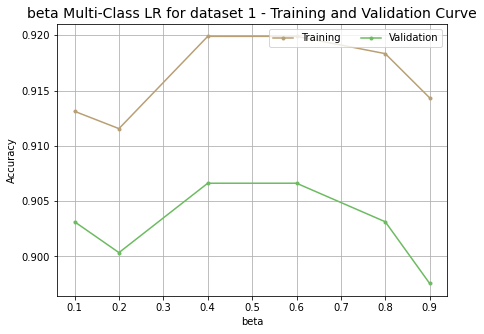

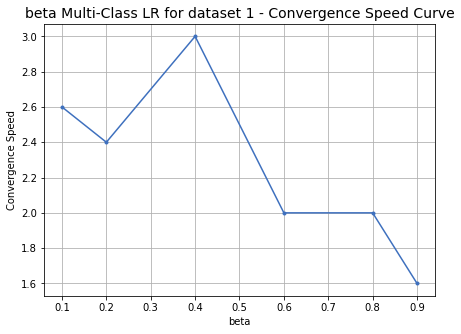

Average training accuracy [0.91311903 0.91155517 0.91989574 0.91989574 0.91833189 0.91433536]
Average validation accuracy [0.90313589 0.90034843 0.90662021 0.90662021 0.90313589 0.89756098]
Average run time [0.2952617  0.26351702 0.33232707 0.25090579 0.23701666 0.18697226]


In [ ]:
# Performance evaluation given different beta values
performance_evaluation('beta', new_dict, X1_train, y1_train, X1_val, y1_val, 'dataset 1')

#### With L1 Regularization 

In [ ]:
# Find the best combination of hyperparameters using the training and validation set -- with l1 regularization 
max_accuracy, new_dict, best_model_list = best_hyperparameters(X1_train, y1_train, X1_val, y1_val, 'l1')
print('Best accuracy : {},  best hyperparameters: {}'.format(max_accuracy, new_dict))

Best accuracy : 0.9128919860627176,  best hyperparameters: {'learning_rate': 0.01, 'beta': 0.6, 'batch_size': 10, 'lambda': 0.001}


In [ ]:
# Evaluation on the test set 
test_set_evaluation(X1_test, y1_test, best_model_list)

By using the best combination of hyperparameters {'learning_rate': 0.01, 'beta': 0.6, 'batch_size': 10, 'lambda': 0.001}, the average accuracy on the test set is 0.811142061281337


#### With L2 Regularization

In [ ]:
# Find the best combination of hyperparameters using the training and validation set -- with l2 regularization 
max_accuracy, new_dict, best_model_list = best_hyperparameters(X1_train, y1_train, X1_val, y1_val, 'l2')
print('Best accuracy : {},  best hyperparameters: {}'.format(max_accuracy, new_dict))

Best accuracy : 0.9212543554006969,  best hyperparameters: {'learning_rate': 0.1, 'beta': 0.1, 'batch_size': 10, 'lambda': 0.1}


In [ ]:
# Evaluation on the test set 
test_set_evaluation(X1_test, y1_test, best_model_list)

By using the best combination of hyperparameters {'learning_rate': 0.1, 'beta': 0.1, 'batch_size': 10, 'lambda': 0.1}, the average accuracy on the test set is 0.8384401114206129


### Multi-Class Logistic Regression for Dataset 2

#### No Regularization

In [ ]:
max_accuracy, new_dict, best_model_list = best_hyperparameters(X2_train, y2_train, X2_val, y2_val, None)
print('Best accuracy : {},  best hyperparameters: {}'.format(max_accuracy, new_dict))

Best accuracy : 0.5837037037037037,  best hyperparameters: {'learning_rate': 0.1, 'beta': 0.1, 'batch_size': 10}


In [ ]:
test_set_evaluation(X2_test, y2_test, best_model_list)

By using the best combination of hyperparameters {'learning_rate': 0.1, 'beta': 0.1, 'batch_size': 10}, the average accuracy on the test set is 0.5455621301775148


[0.54723247 0.50110701 0.49225092 0.49594096 0.49409594 0.48228782] [0.5762963  0.53777778 0.52888889 0.51703704 0.51407407 0.51703704] [10, 20, 40, 60, 80, 100]


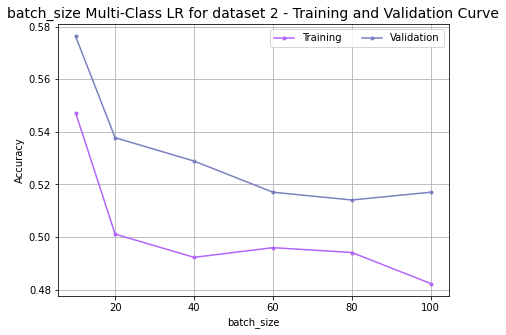

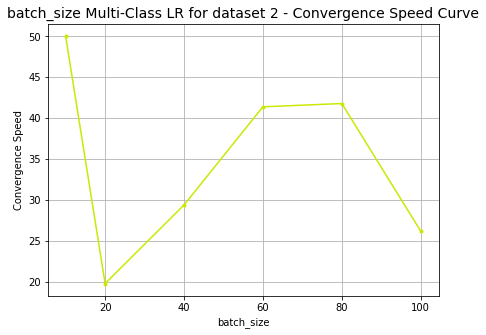

Average training accuracy [0.54723247 0.50110701 0.49225092 0.49594096 0.49409594 0.48228782]
Average validation accuracy [0.5762963  0.53777778 0.52888889 0.51703704 0.51407407 0.51703704]
Average run time [1.43667379 0.30114929 0.25202293 0.26568408 0.21178923 0.11684419]


In [ ]:
performance_evaluation('batch_size', new_dict, X2_train, y2_train, X2_val, y2_val, 'dataset 2')

[0.46642066 0.54243542 0.54612546 0.55202952 0.5501845 ] [0.50666667 0.56444444 0.57333333 0.5837037  0.59407407] [0.001, 0.01, 0.1, 0.2, 0.3]


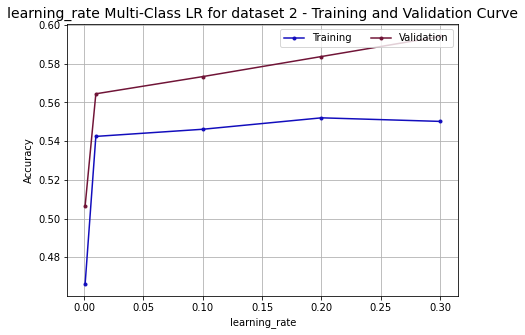

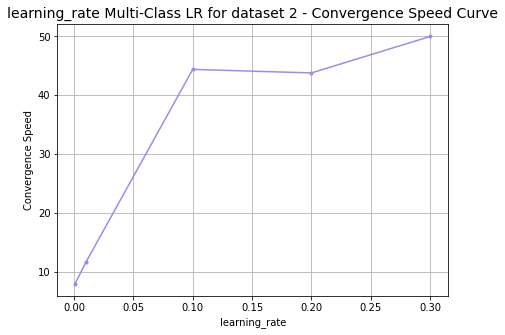

Average training accuracy [0.46642066 0.54243542 0.54612546 0.55202952 0.5501845 ]
Average validation accuracy [0.50666667 0.56444444 0.57333333 0.5837037  0.59407407]
Average run time [0.22529883 0.32836478 1.28347562 1.25489018 1.44202423]


In [ ]:
performance_evaluation('learning_rate', new_dict, X2_train, y2_train, X2_val, y2_val, 'dataset 2')

[0.54944649 0.55276753 0.5501845  0.52509225 0.53357934 0.54464945] [0.58074074 0.58074074 0.5762963  0.57185185 0.57481481 0.56444444] [0.1, 0.2, 0.4, 0.6, 0.8, 0.9]


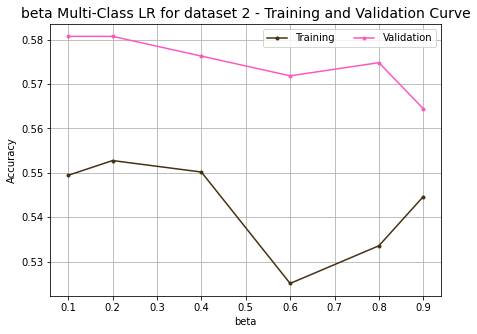

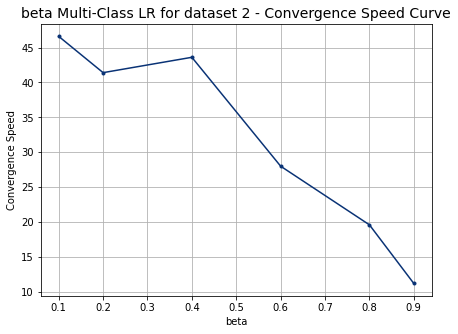

Average training accuracy [0.54944649 0.55276753 0.5501845  0.52509225 0.53357934 0.54464945]
Average validation accuracy [0.58074074 0.58074074 0.5762963  0.57185185 0.57481481 0.56444444]
Average run time [1.34321876 1.18950817 1.23976136 0.80495503 0.56537924 0.31817478]


In [ ]:
performance_evaluation('beta', new_dict, X2_train, y2_train, X2_val, y2_val, 'dataset 2')

#### With L1 Regularization

In [ ]:
max_accuracy, new_dict, best_model_list = best_hyperparameters(X2_train, y2_train, X2_val, y2_val, 'l1')
print('Best accuracy : {},  best hyperparameters: {}'.format(max_accuracy, new_dict))

Best accuracy : 0.6177777777777778,  best hyperparameters: {'learning_rate': 0.3, 'beta': 0.8, 'batch_size': 10, 'lambda': 0.01}


In [ ]:
test_set_evaluation(X2_test, y2_test, best_model_list)

By using the best combination of hyperparameters {'learning_rate': 0.3, 'beta': 0.8, 'batch_size': 10, 'lambda': 0.01}, the average accuracy on the test set is 0.39289940828402364


#### With L2 Regularization

In [ ]:
max_accuracy, new_dict, best_model_list = best_hyperparameters(X2_train, y2_train, X2_val, y2_val, 'l2')
print('Best accuracy : {},  best hyperparameters: {}'.format(max_accuracy, new_dict))

Best accuracy : 0.6103703703703702,  best hyperparameters: {'learning_rate': 0.2, 'beta': 0.4, 'batch_size': 10, 'lambda': 0.1}


In [ ]:
test_set_evaluation(X2_test, y2_test, best_model_list)

By using the best combination of hyperparameters {'learning_rate': 0.2, 'beta': 0.4, 'batch_size': 10, 'lambda': 0.1}, the average accuracy on the test set is 0.5609467455621301


### Model Performance Against Hyperparameter Changes

In [22]:
# Hyperparameters 
batch_size = range(1,100);
learning_rate = list(np.linspace(0.01,1,100))
beta_param = list(np.linspace(0.01,1,100))

hyper_params = ['learning_rate', 'beta', 'batch_size']
hyperparam_dict = dict(zip(hyper_params, [learning_rate, beta_param, batch_size])) 

In [23]:
# optimal hyperparameter set
d1_new_dict = {'learning_rate': 0.01, 'beta': 0.6, 'batch_size': 10, 'lambda': 0.001}
d2_new_dict = {'learning_rate': 0.1, 'beta': 0.1, 'batch_size': 10, 'lambda': 0.1}

#### Batch Size

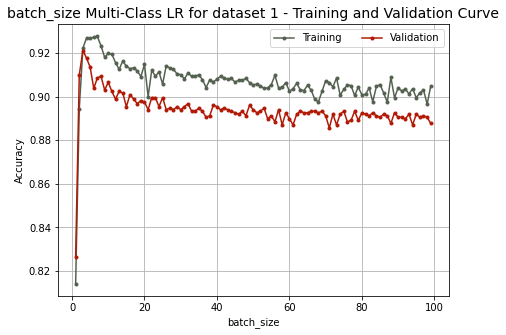

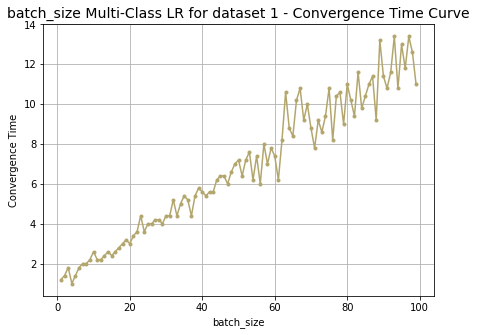

In [28]:
# dataset 1
performance_evaluation('batch_size', d1_new_dict, X1_train, y1_train, X1_val, y1_val, 'dataset 1')

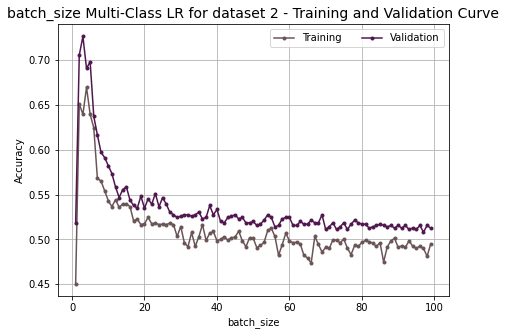

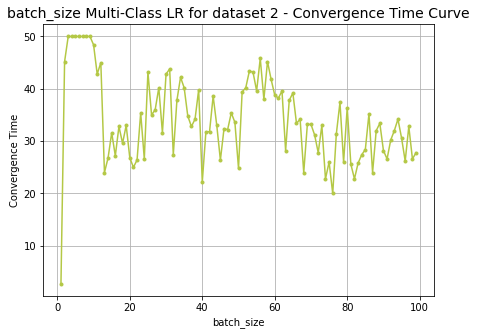

In [29]:
# dataset 2
performance_evaluation('batch_size', d2_new_dict, X2_train, y2_train, X2_val, y2_val, 'dataset 2')

#### Learning Rate

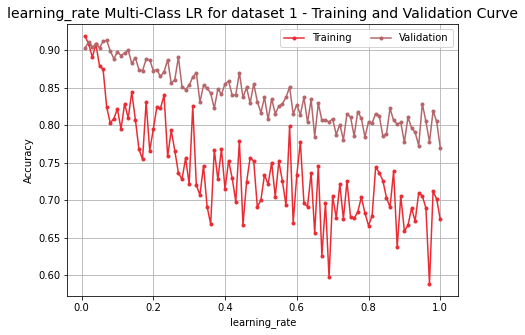

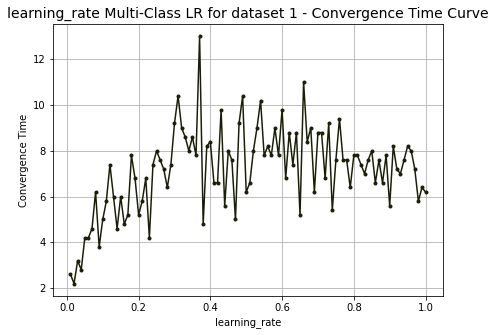

In [30]:
# dataset 1
performance_evaluation('learning_rate', d1_new_dict, X1_train, y1_train, X1_val, y1_val, 'dataset 1')

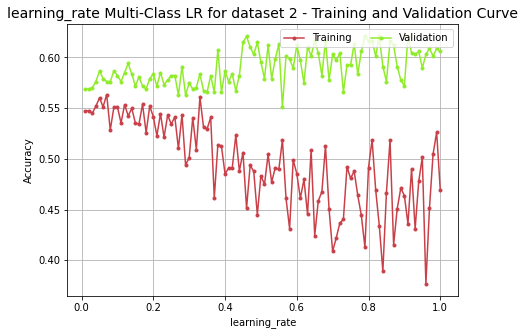

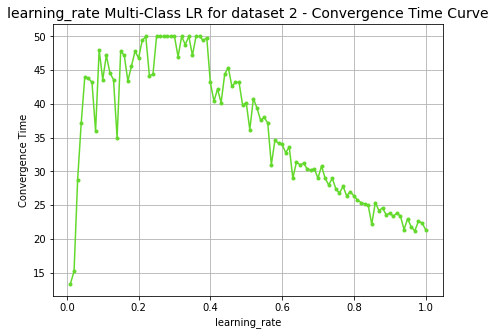

In [31]:
# dataset 2
performance_evaluation('learning_rate', d2_new_dict, X2_train, y2_train, X2_val, y2_val, 'dataset 2')

#### Beta

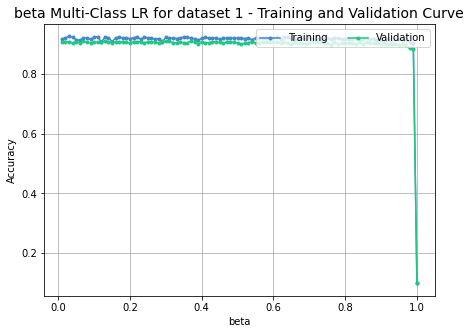

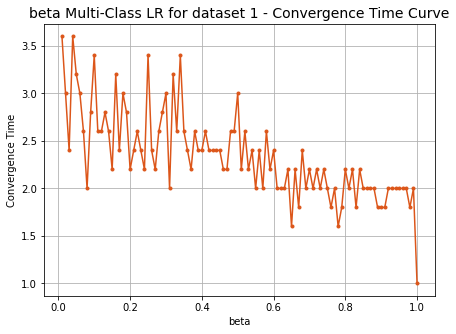

In [32]:
# dataset 1
performance_evaluation('beta', d1_new_dict, X1_train, y1_train, X1_val, y1_val, 'dataset 1')

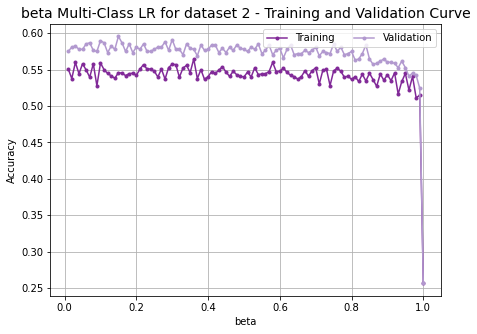

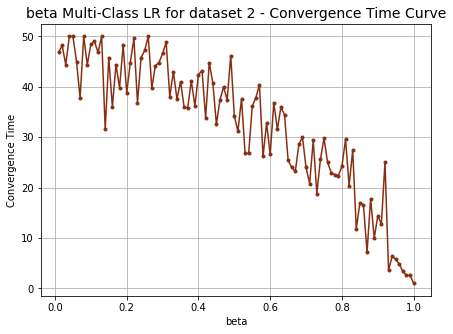

In [33]:
# dataset 2
performance_evaluation('beta', d2_new_dict, X2_train, y2_train, X2_val, y2_val, 'dataset 2')

## KNN Training and Testing

In [ ]:
n_neighbors = list(np.arange(2, 21))
metric = ['euclidean', 'manhattan', 'minkowski']
weights = ['uniform', 'distance']
hyper_params = ['n_neighbors', 'metric', 'weights']
k = 5

def knn_classification(x_train_list, y_train_list, x_test_list, y_test_list):
  '''
  : return max_accuracy: the maximum average accuracy using one of the five best hyperparameters 
  : return new_dict: The best combination of hyperparameters that gives the max accuracy 
  : return best_model_list: The 5 set of best models 
  '''

  accuracy = np.empty((k))
  max_accuracy = 0
  for n in n_neighbors: 
    for m in metric:
      for w in weights:
        model_list = []
        for i in range(k):
          knn = KNeighborsClassifier(n_neighbors=n, metric=m, weights=w)
          clf = knn.fit(x_train_list[i], y_train_list[i])
          y_pred = clf.predict(x_test_list[i])
          accuracy[i] = metrics.accuracy_score(y_test_list[i], y_pred)
          model_list.append(clf)
        avg_accuracy = np.average(accuracy) 

        if (avg_accuracy > max_accuracy):
          max_accuracy = avg_accuracy
          hyper_list = [n, m, w]
          new_dict = dict(zip(hyper_params, hyper_list))
          best_model_list = model_list

  return max_accuracy, new_dict, best_model_list

def knn_test_evaluation(x_test, y_test, best_model_list):

  accuracy = 0
  for knn in best_model_list:
    y_predict = knn.predict(x_test) # Prediction using the optimal weight 
    accuracy += metrics.accuracy_score(y_test, y_predict)  
  avg_accuracy = accuracy/5

  return avg_accuracy 


### KNN for Dataset 1

In [ ]:
 max_accuracy, new_dict, best_model_list = knn_classification(X1_train, y1_train, X1_val, y1_val)
 print("The highest validation accuracy is {}, and the best combination of hyperparameters is {}".format(max_accuracy, new_dict))
 accuracy = knn_test_evaluation(X1_test, y1_test, best_model_list)
 print("Test accuracy using the best combination of hyperparameters is ", accuracy)

The highest validation accuracy is 0.9519163763066201, and the best combination of hyperparameters is {'n_neighbors': 4, 'metric': 'manhattan', 'weights': 'distance'}
Test accuracy using the best combination of hyperparameters is  0.9298050139275766


### KNN for Datatset 2

In [ ]:
 max_accuracy, best_param, best_model_list = knn_classification(X2_train, y2_train, X2_val, y2_val)
 print("The highest accuracy is {}, and the best combination of hyperparameters is {}".format(max_accuracy, best_param))
 accuracy = knn_test_evaluation(X2_test, y2_test, best_model_list)
 print("Test accuracy using the best combination of hyperparameters is ", accuracy)

The highest accuracy is 0.7007407407407407, and the best combination of hyperparameters is {'n_neighbors': 2, 'metric': 'euclidean', 'weights': 'distance'}
Test accuracy using the best combination of hyperparameters is  0.6757396449704143
